
# Can actually by the clinical trials data we can predict the confirmity of cases?

<h3> Alternate Hypothesis - COVID Clinical Markers </h3>

# General Overview

<H3> Task Details </H3>

The initiative is prompted by the suggestion that there may be a link between reduced rates of infection and lower case fatality rates associated with COVID-19 in countries that recommend BCG vaccine for all as opposed to countries that recommend BCG only for specific high-risk groups. We hope that the analysis done as part of this task might help discover useful information about the BCG - COVID-19 clinical trials. For example, some insights that may come from this analysis is whether factors such as the strain of BCG, the age at which people have been vaccinated, revaccination, or how long ago people have been vaccinated are important.

<h3> Key Questions for Consideration and what's included in this notebook? </h3>

The dependence of BCG Vaccine effects on COVID-19 Treatment is still under research and is hearing a mixed response from the community. This notebook looks over the Alternate Hypothesis for the BCG COVID-19 AI Challenge. It tends to analyze which clinical factors contribute to cases of COVID-19 getting severe and tries to build a basic ML model to address this.

1. Which patients would require ICU?
2. Which patients would require ventilation?
3. Which patients would seek HCP Support?

To address these problems, this notebook deals with creating a ML Tool that can predict the cases confirmity of the basis of clinical results. If the clinical data can be used to accurately predict the cases confirmity, it can also be used to predict how worse the case gets and the person may seek ICU's / ventilations from there on.



# <a id='main'><h3>Stages of notebook</h3></a>
- [What we actually know?](#knw)
- [Datasets used in notebook](#data)
- [Wrangling the data](#conc)
- [Doing the Machine Learning](#ml)


# <a id='knw'><h3>What we actually know?</h3></a>

The World Health Organization (WHO) characterized COVID-19, caused by SARS-CoV-2, as a pandemic on March 11, while the exponential increase in the number of cases was risking to overwhelm health systems around the world with a demand for ICU beds far above the existing capacity, with regions of Italy being prominent examples

# <a id='data'><h3>The Dataset used in this notebook</h3></a>

This work reports results from the Kaggle challenge Diagnosis of COVID-19 and its clinical spectrum created by the Hospital Israelita Albert Einstein in São Paulo, Brazil.

The dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein in São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.

All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

# <a id='conc'><h3>Wrangling the dataset</h3></a>

<h3> Building a predefined function in R </h3>

In [18]:
# load the required packages 
library(readxl)
library(caret)
library(gbm)
library(pROC)
library(ggplot2)
library(ggthemes)
library(reshape)

In [2]:
BinModelPerformance <- function(current.prediction, prediction.threshold, reference){
  
  classes <- c("positive", "negative")
  
  current.prediction.outcome <- as.factor(ifelse(current.prediction > prediction.threshold, 
                                                 "positive", "negative"))
    
  reference <- as.factor(ifelse(reference, "positive", "negative"))
  
  current.pr<-ediction.outcome <- factor(current.prediction.outcome, 
                                       levels =   classes)
    
  reference <- factor( reference, levels = classes)
  
  # Confusion matrix
  print(caret::confusionMatrix(current.prediction.outcome, reference = reference, positive="positive")$table)
  
  x <- data.frame(obs = reference, pred = current.prediction.outcome)
    
  x$positive <- current.prediction
  x$negative <- 1 -  current.prediction
    
  pr2ClassSumm <- caret::twoClassSummary(x, lev = classes )
  
  model.summ <- c(pr2ClassSumm)

  return(model.summ)}


### Drop samples that do not have enough non-NA values
delete.na <- function(DF, n = 0, is.row = TRUE) {
  if(is.row){
    DF[rowSums(!is.na(DF)) >= n,]
  } else {
    DF[,colSums(!is.na(DF)) >= n]
  }}

<h3> Loading the dataset for further wrangling </h3>

In [6]:
#Loading the dataset
data <- as.data.frame(read_excel("../input/covid19/dataset.xlsx"), stringAsFactors=F)
head(data)

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,⋯,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,44477f75e8169d2,13,negative,0,0,0,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,126e9dd13932f68,17,negative,0,0,0,0.2365154,-0.02234027,-0.517413,0.01067657,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,a46b4402a0e5696,8,negative,0,0,0,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,f7d619a94f97c45,5,negative,0,0,0,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,d9e41465789c2b5,15,negative,0,0,0,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,75f16746216c4d1,9,negative,0,0,0,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA



<h3> Data Preparation </h3>

* Removing special characters, spaces and symbols
* Dealing with missing values

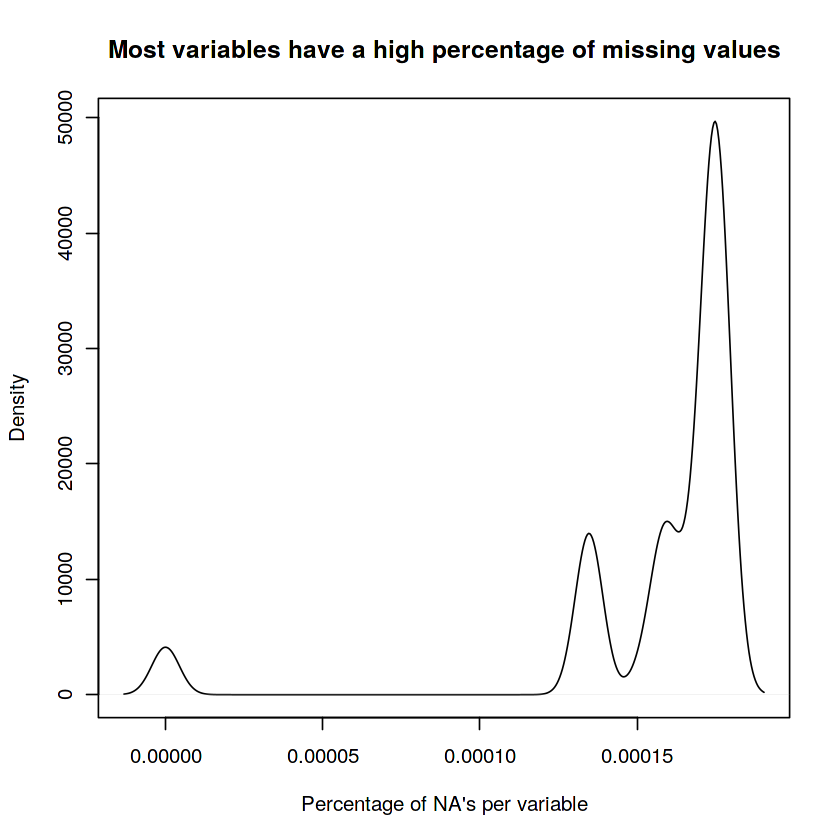

In [7]:
# make variable names syntactically valid
names(data) <- make.names(names(data))
data$Patient.ID <- NULL

# Replace column values that should be empty for NA
data[data =='Não Realizado'] <- NA
data[data =='not_done'] <- NA
data[data =='<1000'] <- 500

data$Urine...Leukocytes <- as.integer(data$Urine...Leukocytes)
data$Urine...pH <- as.integer(data$Urine...pH)

# convert string values to factors
ind <- sapply(data, is.character)
data[ind] <- lapply(data[ind], factor)

data$Lipase.dosage <- as.factor(data$Lipase.dosage)

outcome.var<-"SARS.Cov.2.exam.result"
data[, outcome.var] <- as.integer(data[, outcome.var]) - 1

countNA <- function(x){sum(is.na(x))}

x <-apply(data, 2, countNA)/nrow(data)

plot(density(x/nrow(data)), 
     main = "Most variables have a high percentage of missing values", 
     xlab = "Percentage of NA's per variable")

As observed below, most of the variables have a very high percentage of missing values (NA's). The concern here is that these predictors may become zero-variance predictors when the data are split into cross-validation/bootstrap sub-samples in the predictive modeling we propose. 

Hence, we remove variables that have too many missing data points (>= 95%). We also remove samples that are too sparse in laboratory data, we choose to keep negative samples that have at least 10 variables with data points available. This is performed to avoid an overfit scenario where a few samples (sparse but positive) may have an undue influence on the predictive model.

In [9]:
#Removing certain values

data.saved <- data
data.size <- nrow(data)
not.na.pct <- 0.05
data <- delete.na(data, n = data.size * not.na.pct, is.row = FALSE)


data.pos <- data[data$SARS.Cov.2.exam.result==1,]
data.neg <-  data[data$SARS.Cov.2.exam.result==0,]

### delete poor samples
min.non.na.vars <- 10
data.neg <- delete.na(data.neg, n = min.non.na.vars)

data <- rbind(data.pos, data.neg)
head(data)

,Patient.age.quantile,SARS.Cov.2.exam.result,Patient.addmited.to.regular.ward..1.yes..0.no.,Patient.addmited.to.semi.intensive.unit..1.yes..0.no.,Patient.addmited.to.intensive.care.unit..1.yes..0.no.,Hematocrit,Hemoglobin,Platelets,Mean.platelet.volume,Red.blood.Cells,⋯,Parainfluenza.2,Neutrophils,Urea,Proteina.C.reativa.mg.dL,Creatinine,Potassium,Sodium,Influenza.B..rapid.test,Influenza.A..rapid.test,Strepto.A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
68,7,1,0,0,0,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
285,16,1,1,0,0,NA,NA,NA,NA,NA,⋯,not_detected,NA,NA,NA,NA,NA,NA,NA,NA,NA
514,10,1,0,0,0,NA,NA,NA,NA,NA,⋯,not_detected,NA,NA,NA,NA,NA,NA,NA,NA,NA
569,2,1,0,0,0,0.9918382,0.7921876,-0.3415477,1.4691876,1.6534758,⋯,not_detected,-0.4142149,-0.5139092,NA,-0.3223401,-0.0586259,0.1437519,NA,NA,NA
677,15,1,0,0,0,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
885,15,1,1,0,0,-0.4959191,-0.3982758,-0.7184020,-0.4380969,-0.5679496,⋯,not_detected,1.2821176,0.9747588,-0.2472455,0.1601135,-1.0472720,0.8625116,NA,NA,NA


# <a id='ml'><h3>Doing the Machine Learning</h3></a>

Digging down into ML Algorithms for deeper understanding. To predict the likelihood that a patient is infected with the SARS-Cov2 virus, we split the dataset randomly into training and testing tests in a train-to-test split ratio of 2/3. We decompose the dataset such that the outcome variable also follows the same split ratio between train and test sets.

In [10]:
set.seed(18101987)

SPLIT.RATIO <- 2/3
train.index <- createDataPartition(data$SARS.Cov.2.exam.result, p = SPLIT.RATIO, list = FALSE)
train <- data[train.index,]
test <- data[-train.index,]

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress




We train a GBM model using the remaining dataset variables as predictors. We also define a bag fraction which defines the fraction of the training set observations randomly selected to propose the next tree in the expansion. This introduces randomnesses into the model fit and reduces overfitting.

In [13]:
train.features <- setdiff(names(train), c(outcome.var, "Patient.ID"))
myformula <- as.formula(paste0(outcome.var," ~ ", paste0(train.features, collapse="+")))

BAG.FRACTION <- 0.8

gbm.model <- gbm(myformula, 
                 data = train,
                 n.trees = 500,
                 bag.fraction = BAG.FRACTION,
                 verbose=FALSE)

Distribution not specified, assuming bernoulli ...


Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 35: Parainfluenza.2 has no variation.”


<h3> Model Interpretability </h3>
We evaluate model interpretability by looking at the relative importance of the variables as well as their conditional dependency probability relative to the outcome variable. Model explanations are important because they can be used to improve medical decision-making and guide policy-making initiatives.

The top 10 most important variables returned by the model are given below. The importance measures are normalized and they are based on the number of times a variable is selected for tree splitting, weighted by the improvement to the model as a result of each split, and averaged over all trees.

                                                                                          var
Rhinovirus.Enterovirus                                                 Rhinovirus.Enterovirus
Influenza.B                                                                       Influenza.B
Leukocytes                                                                         Leukocytes
Platelets                                                                           Platelets
Inf.A.H1N1.2009                                                               Inf.A.H1N1.2009
Eosinophils                                                                       Eosinophils
Patient.addmited.to.regular.ward..1.yes..0.no. Patient.addmited.to.regular.ward..1.yes..0.no.
Respiratory.Syncytial.Virus                                       Respiratory.Syncytial.Virus
Monocytes                                                                           Monocytes
Patient.age.quantile                                        

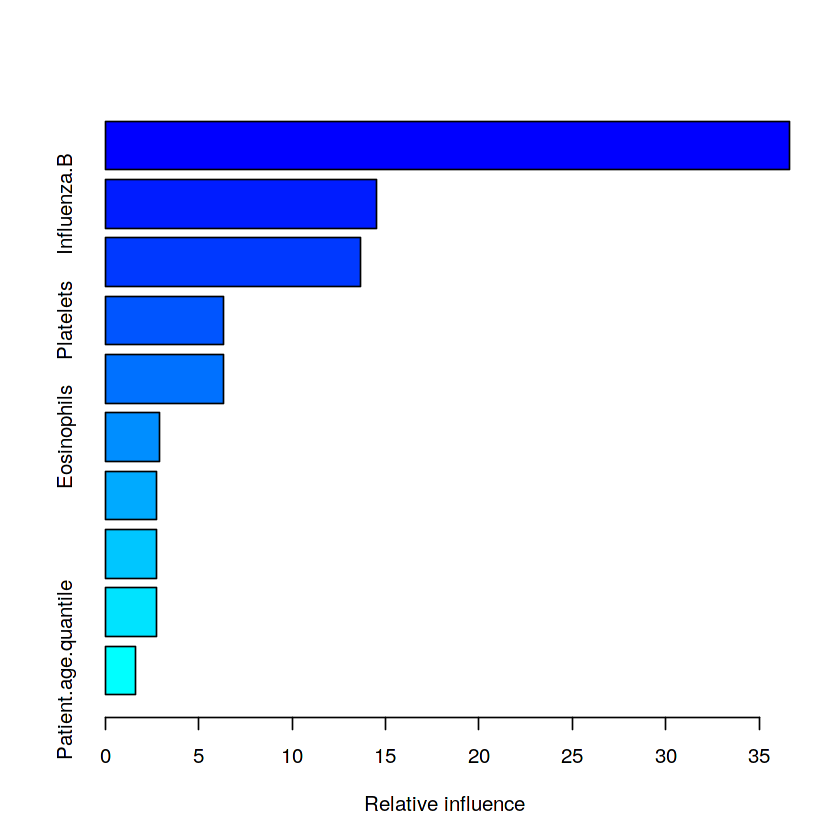

In [14]:
model.summary <- summary(gbm.model, cBars=10)
print(model.summary[1:10,])

<h3> The analyses from the assumptions made here </h3>

Above is the most important parametric clinical factors that we can look for while differentiating a covid-19 positive and negative person. I import two charts from the ealier notebooks of mine to provide an add-on to this. The variables above can be taken into consideration for the model building task as a differentiator.

<iframe src='https://flo.uri.sh/visualisation/2260261/embed' frameborder='0' scrolling='no' style='width:100%;height:600px;'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/2260261/?utm_source=embed&utm_campaign=visualisation/2260261' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>

<iframe src='https://flo.uri.sh/visualisation/2016047/embed' frameborder='0' scrolling='no' style='width:100%;height:600px;'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/2016047/?utm_source=embed&utm_campaign=visualisation/2016047' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>

We also analyze the conditional probability plots of the top 5 most important variables below, where the x-axis represents the predictor and the y-axis represents the likelihood of infection (numbers are normalized). We observe the following:

When Rhinovirus.Enterovirus, Influenza.B or Inf.A.H1N1.2009 are not detected, patients are more likely to test positive for SARS-COV2
Patients with low Leukocytes or Platelets are more likely to test positive for SARS-COV2

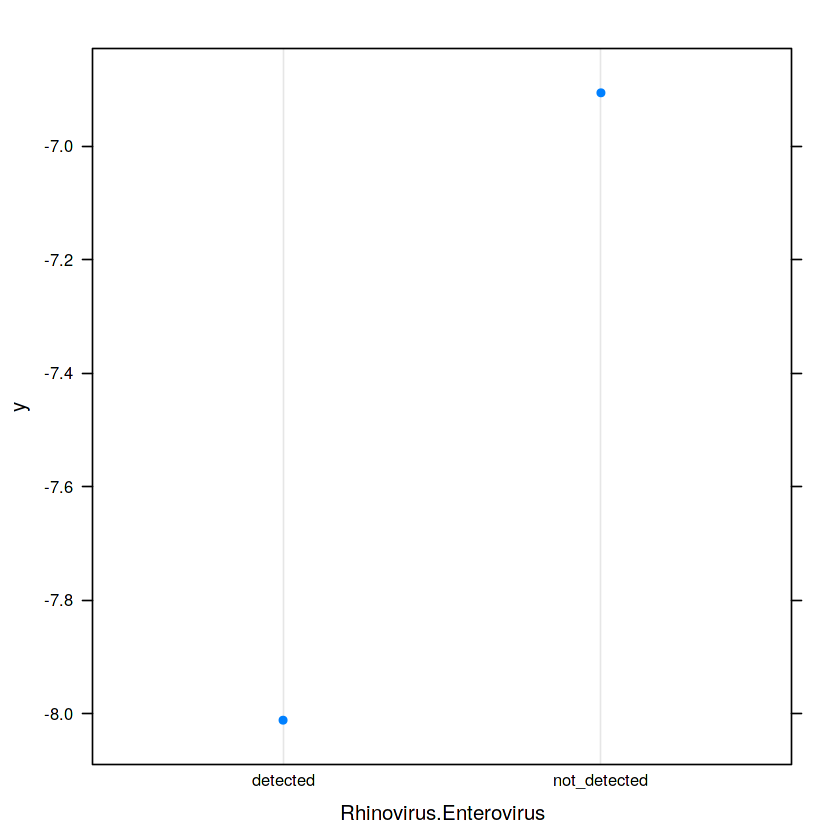

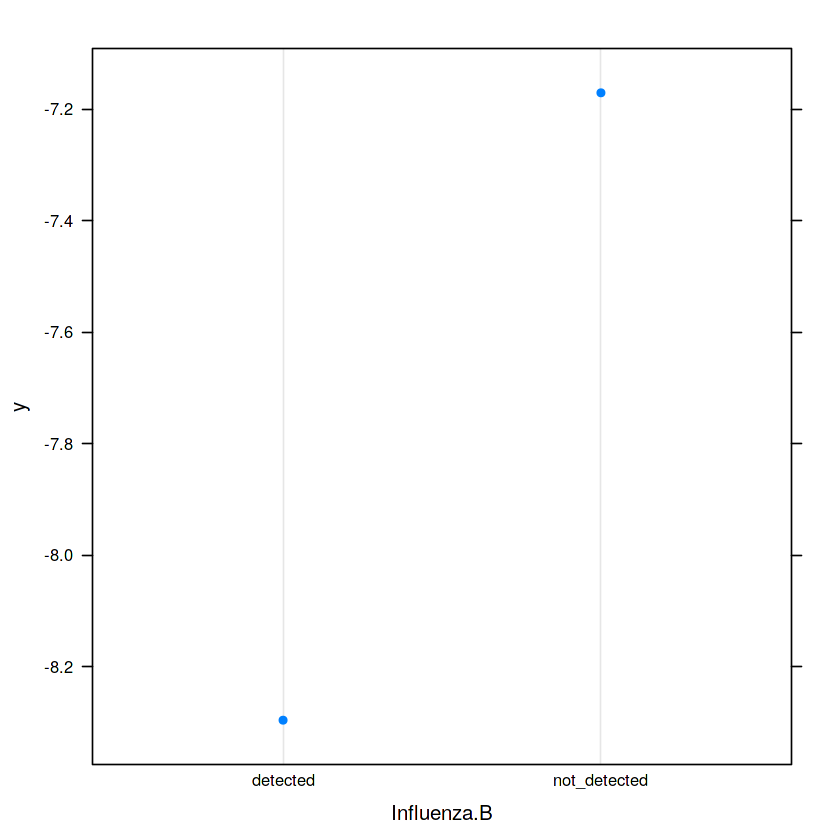

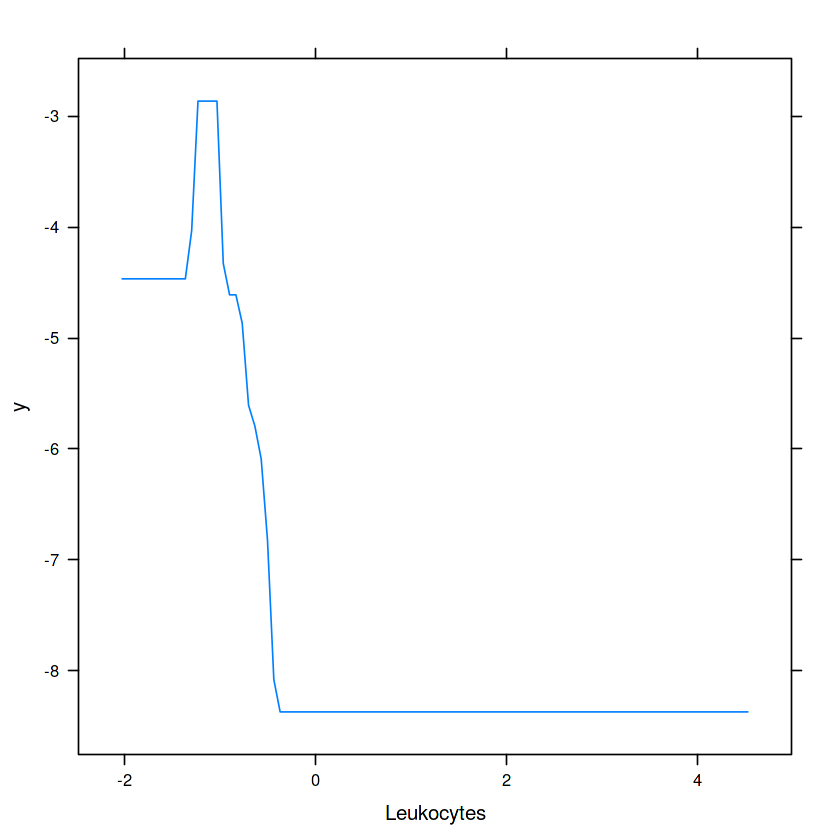

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


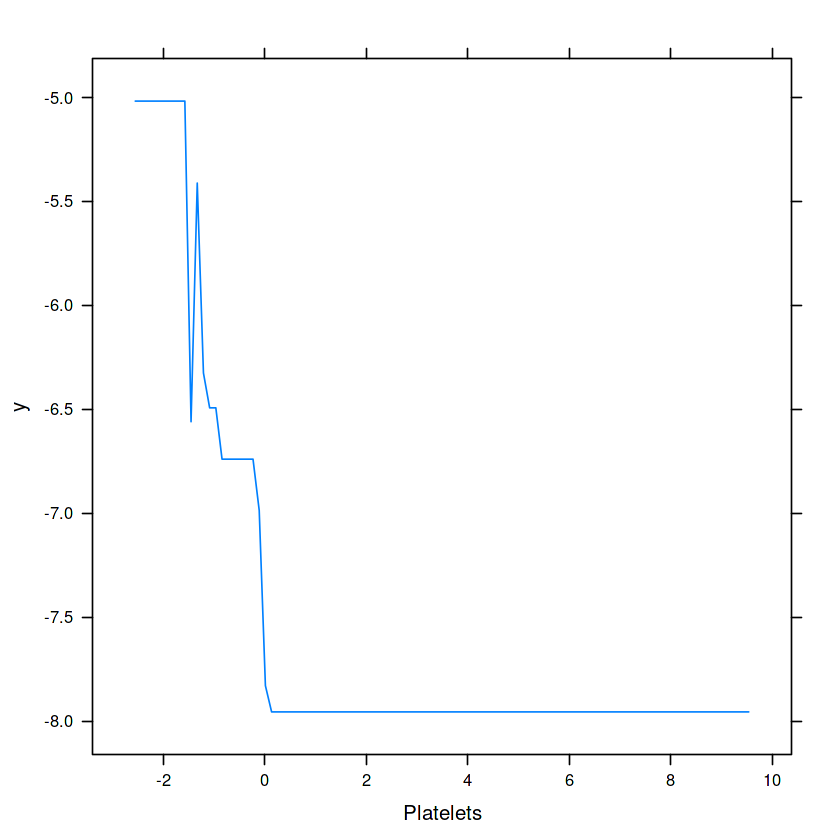

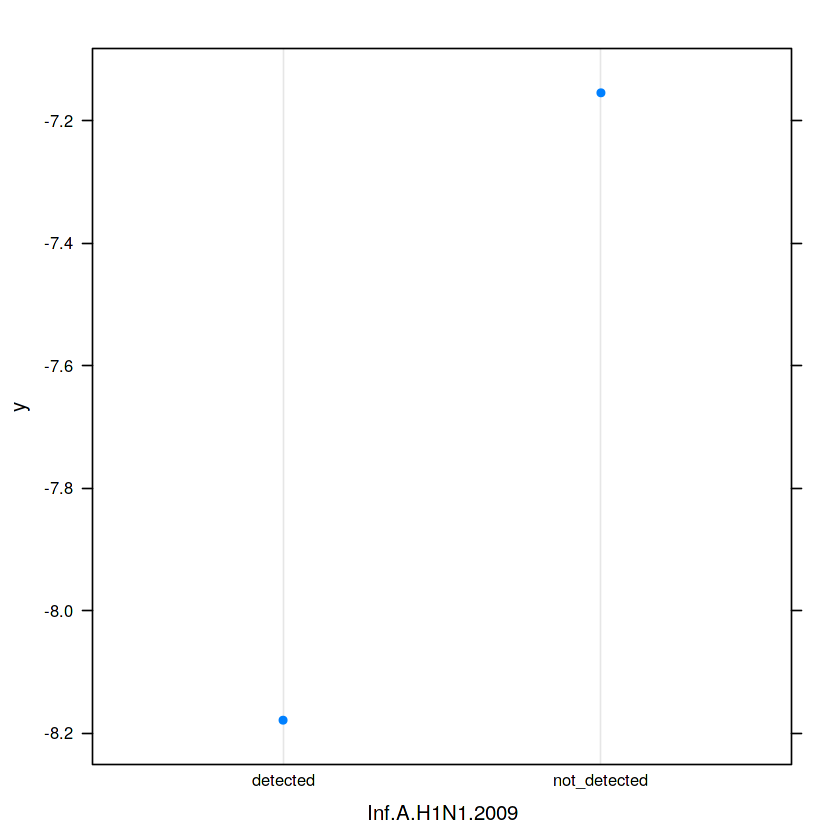

In [15]:
lapply(as.character(model.summary$var[1:5]), plot.gbm, x = gbm.model)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



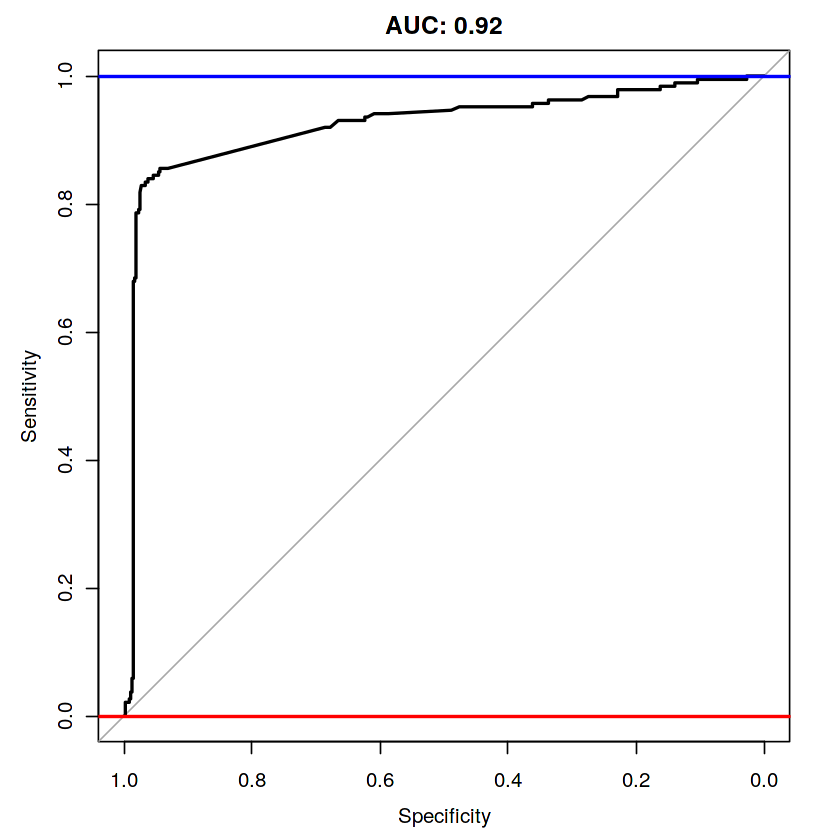

In [17]:
test.current.prediction <-predict(gbm.model, newdata = test, n.trees = 500,type="response")

x.roc<-roc(response=test$SARS.Cov.2.exam.result, predictor=test.current.prediction)

plot(x.roc, ylim=c(0,1),
     main=paste('AUC:',round(x.roc$auc[[1]],2)))

abline(h=1,col='blue',lwd=2)
abline(h=0,col='red',lwd=2)

Below we can visualize how the choice of the threshold can influence the sensitivity and specificity of the model (in-sample analysis using train set). A model with high sensitivity achieves good results in finding positive patients among those true positive patients. However, the number of patients predicted to be positive can be too high and impact the model's specificity. Moreover, the hospital may not have enough resources to apply the necessary procedures for all patients assigned with a positive label if that number is too high. Hence, an ideal model is one that is well-balanced, i.e., one that has high sensitivity but it does not over-assign patients with positive labels.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



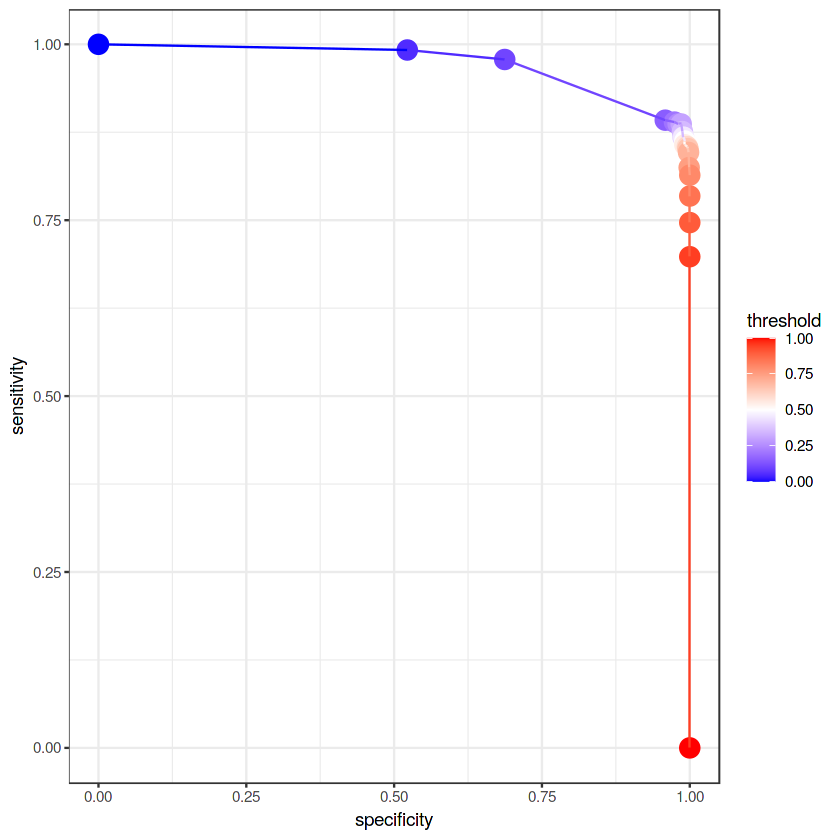

In [19]:
train.current.prediction <- predict(gbm.model, 
                                    newdata = train, 
                                    n.trees = 500,
                                    type="response")

x.roc <- roc(response = train$SARS.Cov.2.exam.result, 
             predictor = train.current.prediction)

cc <- coords(x.roc, 
             seq(from = 0, to = 1, by = 0.05), 
             ret = c("sensitivity", "specificity", "threshold"), 
             transpose = FALSE)

mid <- median(cc$threshold)

ggplot(cc, aes(x=specificity, 
               y=sensitivity,
               color=threshold, 
               fill=threshold)) + 
geom_point(size = 5) + 
geom_line() +
theme_bw() +
scale_color_gradient2(midpoint=mid, low="blue", mid="white", high="red", space ="Lab" ) +
scale_fill_gradient2(midpoint=mid, low="blue", mid="white", high="red", space ="Lab" )

To determine which likelihood to choose and how to determine which patients to prioritize as more likely to be infected we discuss different scenarios which can be tied to distinct hospital-, city-, state- or country-specific policies. For each scenario, we will select the threshold from the train set that optimizes a given target objective function driven by the policy in the scenario in case.

<h3> Scenario 1: High availability of resources </h3>

In Scenario 1, we assume that the hospital has high availability of resources. In that way, the model can be relaxed and over-estimate the number of positive cases. Hence, our objective function is one that maximizes sensitivity.

We use the train data to select the threshold that maximizes model's sensitivity. We then apply this threshold in the predicted probabilities in the test set. The procedure returns a probability threshold of 1.6% and the model presents a high sensitivity value of 95%, as intended. However, the high recall comes at the cost of specificity, which presents a low value of 34%. Moreover, about 74% of the patients from the test set were labeled as positive, hence the model has limited usage as a prioritization tool.



In [20]:
library(pROC)
train.current.prediction <- predict(gbm.model, 
                                    newdata = train, 
                                    n.trees = 500,
                                    type="response")
                             

best.th <- coords(roc = x.roc, 
                  x = 1, 
                  input = "sensitivity", 
                  transpose = FALSE)$threshold

print(paste0("Optimal threshold = ", best.th))

oos.current.prediction <- predict(gbm.model, 
                                  newdata = test, 
                                  n.trees = 500,
                                  type="response")

print(paste0("Pct patients predicted as infected = ", sum(oos.current.prediction > best.th) / length(oos.current.prediction)))

oos.x.roc <- roc(test$SARS.Cov.2.exam.result,  
                 predictor = oos.current.prediction)

BinModelPerformance(oos.current.prediction, best.th, test$SARS.Cov.2.exam.result)

[1] "Optimal threshold = 0.0164039401827982"
[1] "Pct patients predicted as infected = 0.74251497005988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in confusionMatrix.default(current.prediction.outcome, reference = reference, :
“Levels are not in the same order for reference and data. Refactoring data to match.”


          Reference
Prediction positive negative
  positive      179      317
  negative        8      164


ERROR: Error in caret::twoClassSummary(x, lev = classes): levels of observed and predicted data do not match


<h3> Scenario 2: Limited resources </h3>
In Scenario 2, we assume an environment with limited resources and hence a reduction in model's sensitivity is acceptable if we can obtain a well-balanced model, overall. For that purpose, we choose as objective function one that maximizes the Youden J's statistic defined as $max(sensitivity + specificy)$.

Below, we can visualize the influence of the threshold in the value of the corresponding Youden J's statistic (in-sample analysis). We observe that a too low or too high threshold values lead to suboptimal balance in the model.

After making a prediction on the test set, we will then choose a threshold from the train set that maximizes the Youden J's statistic to achieve a well-balanced model. We observe that the model under Scenario 2 now delivers a Sensitivity of 84% compared to 95% from Scenario 1. However, it returns a Specificity of 96% while maintaining a high AUC of 92% (as the choice of threshold does not influence the AUC), hence delivering a more well-balanced model as expected. Moreover, now the model only assigns 26% of the test set with positive labels, showing to be useful as a potential patient prioritization tool.

In [21]:
oos.current.prediction <- predict(gbm.model, 
                                  newdata = test, 
                                  n.trees = 500,
                                  type="response")


#obtain optimum threshold
best.th <- coords(x.roc, "best", 
                  ret = "threshold", 
                  transpose = FALSE,
                  best.method = "youden")$threshold

print(paste0("Optimal threshold = ", best.th))

print(paste0("Pct patients predicted as infected = ", 
             sum(oos.current.prediction > best.th) / length(oos.current.prediction)))

BinModelPerformance(oos.current.prediction, best.th,  test$SARS.Cov.2.exam.result)

oos.x.roc <- roc(test$SARS.Cov.2.exam.result, predictor = oos.current.prediction)

# OUT-OF-SAMPLE ROC
plot(oos.x.roc, 
     ylim = c(0,1), 
     print.thres = "best", 
     print.thres.best.method = "youden",
     main = paste('AUC:',round(oos.x.roc$auc[[1]],2)))

abline(h = 1,col = 'blue', lwd = 2)
abline(h = 0,col = 'red', lwd = 2)

[1] "Optimal threshold = 0.296386865354093"
[1] "Pct patients predicted as infected = 0.269461077844311"


Warning message in confusionMatrix.default(current.prediction.outcome, reference = reference, :
“Levels are not in the same order for reference and data. Refactoring data to match.”


          Reference
Prediction positive negative
  positive      158       22
  negative       29      459


ERROR: Error in caret::twoClassSummary(x, lev = classes): levels of observed and predicted data do not match


<h3> Scenario 3: Limited resources, different policies </h3>
In Scenario 3, we incorporate the assumption that different hospitals might have different policies on what is an acceptable value for sensitivity or have different capacities to test prioritized patients as well as have different prevalence levels. Hence, we generalize the models studied under Scenarios 1 and 2 by proposing a parameterized model with a cost function that allows doctors to over- or under-weight false negative classification as compared with a false positive classification depending on a target policy as well as input prevalence as input parameter.

Our objective function is

$max(sensitivity + r*specificy)$,

where

$r = 1 - prevalence / cost * prevalence$

and $r$ is the relative cost of a false negative classification (as compared with a false positive classification).Different countries and regions can have different prevalence, while different hospitals might have different policies to define the $cost$ parameter.

Our findings indicate that a practical model can be delivered with both specificity and sensitivity greater than 85% with the percentage number of patients ($num.positivie.pct$) labeled as positive lower than 30%, hence serving as a relevant prioritization tool. Moreover, the model is parametrized to allow for easy fine-tuning to adjust for target Sensitivity, prevalence or max number of patients to be prioritized.

prevalence <- 0.1

summ <- list()
num.positive.pct <- num.positive <- auc.summ <- vector()

cost.min <- 1
cost.max <- 200

# to do Vectorize 
for(cost in seq(from = cost.min, to = cost.max, by = 1)){

#obtain optimum threshold
best.th<-coords(x.roc, "best", 
                ret="threshold", 
                transpose = FALSE, 
                best.method="youden", 
                best.weights=c(cost, prevalence))$threshold 


oos.current.prediction <- predict(gbm.model, 
                                  newdata = test, 
                                  n.trees = 500,
                                  type="response")

#calculates pct/number of patients labeled as positive
num.positive.pct[cost] <- sum(oos.current.prediction > best.th) / length(oos.current.prediction)
num.positive[cost] <- sum(oos.current.prediction > best.th)

summ[[cost]] <- BinModelPerformance(oos.current.prediction, 
                                    best.th, 
                                    test$SARS.Cov.2.exam.result)

oos.x.roc <- roc(test$SARS.Cov.2.exam.result, predictor = oos.current.prediction)

auc.summ[cost] <- auc(oos.x.roc)

}

df.summ <- data.frame(matrix(unlist(summ), nrow = length(summ), byrow = T))

df.summ$num.positive <- num.positive
df.summ$num.positive.pct <- num.positive.pct
df.summ$auc <- auc.summ
df.summ$cost <- cost.min:cost.max

names(df.summ) <- c(names(summ[[1]]), 
                    "num.positive",  
                    "num.positive.pct", 
                    "auc",
                    "cost")

df.summ$ROC <- NULL
mdata <- melt(df.summ, id = c("cost","num.positive", "num.positive.pct"))

ggplot(mdata, aes(x = cost, y = value)) + 
  geom_line(aes(color = variable)) + 
  theme_bw()

ggplot(mdata, aes(x = num.positive.pct, y = value)) + 
  geom_line(aes(color = variable)) + 
  theme_bw()

<h3> Practical Applications </h3>   

In practice, health workers/hospitals using the proposed model would define a policy for a minimum acceptable Sensitivity level or a target number of patients to be prioritized as well as specify current prevalence. These parameters will serve as input for the model to determine patients that would be prioritized as likely to test positive. The model would then output a binary indicator for SARS-CoV-2 infection, likelihood measure and accuracy. The model's output can be used as a tool for prioritization and to support further medical decision making processes. On a periodic basis, input parameters and hospital's policy can be updated depending on health system conditions. The model would then be re-trained also incorporation newly available data.

<h3> Conclusions </h3>
In this work, we showed that it is possible to predict the test result for SARS-CoV-2 based on the results of laboratory tests commonly collected for a suspected COVID-19 case by analyzing a sample of 5644 patients of which 558 tested positive for SARS-CoV-2 from the Hospital Israelita Albert Einstein.

The proposed model is of practical application with 92% AUC and Sensitivity/Specificity levels greater than 85% depending on target policies/scenarios. The model has high interpretability further showing that patients admitted with COVID-19 symptoms who tested negative for Rhinovirus Enterovirus, Influenza B and Inf.A.H1N1.2009 and presented low levels of Leukocytes and Platelets were more likely to test positive for SARS-CoV-2.